This notebook is the first of two notebooks to help plot our products using rasterio.

We simply take all the raster products we produced in the last notebook and reproject them to lat/lon coordinates (i.e. `epsg:4326`) for visualization.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from orinoco import reproject_arr_to_match_profile, reproject_arr_to_new_crs
from pathlib import Path
import glob
from tqdm import tqdm

# Directories of Orinoco Products

Again there are two options:

1. `stamen_terrain_12`
2. `google_16`

Toggle the map name to change. **We assume you have run the previous notebooks using said option.**

In [2]:
# options are `stamen_terrain_12` or `google_16`
map_name = 'stamen_terrain_12'  

In [3]:
data_path = Path(f'data/{map_name}')
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

# Directory of Our Reprojected Rasters

In [4]:
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')
products_for_map_dir_4326.mkdir(exist_ok=True)

Let's visualize one of the rasters for sanity sake.

In [5]:
with rasterio.open(data_path/f'{map_name}.tif') as ds:
    src_profile = ds.profile
    src_arr = ds.read()
src_arr_rgb = src_arr.transpose([1, 2, 0])[...,:3]


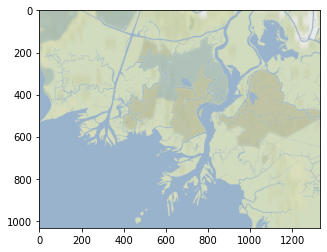

In [6]:
plt.imshow(src_arr_rgb)

# Reprojecting One Raster

In [7]:
if map_name == 'stamen_terrain_12':
    target_resolution = 0.0003
elif map_name == 'google_16':
    #  divide by 15 if really want the 2 meter raster
    #  Using the same resolution for both masks ensures that
    #  we have approximately the same indices for all viz
    target_resolution = 0.0003 #/ 15
else:
    raise ValueError('only works for google_16 and stamen_terrain_12')


src_arr_4326, src_profile_4326 = reproject_arr_to_new_crs(src_arr, 
                                                          src_profile, 
                                                          'epsg:4326',
                                                          resampling='nearest',
                                                          target_resolution=target_resolution
                                                          )
src_arr_4326.shape

(4, 943, 1400)

We save the reprojected raster.

In [8]:
src_profile_4326['dtype'] = 'uint8'
with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif', 'w', **src_profile_4326) as ds:
    ds.write(src_arr_4326.astype(np.uint8))

Let's visualize the raster as a sanity check.

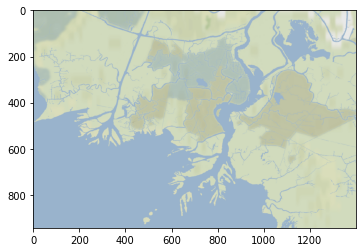

In [9]:
src_arr_rgb_4326 = src_arr_4326.transpose([1, 2, 0])[...,:3].astype(int)
plt.imshow(src_arr_rgb_4326)

# Reprojecting the Rest

We collect all the tif files (rasters) in our product directory and automate the previous process using the profile to ensure they all are reprojected to the same CRS and frame.

In [10]:
raster_data = list(products_for_map_dir.glob('*.tif'))
raster_data

[PosixPath('products/stamen_terrain_12/distance.tif'),
 PosixPath('products/stamen_terrain_12/ocean_mask.tif'),
 PosixPath('products/stamen_terrain_12/water_mask_original.tif'),
 PosixPath('products/stamen_terrain_12/segments_along_interface.tif'),
 PosixPath('products/stamen_terrain_12/channel_mask.tif'),
 PosixPath('products/stamen_terrain_12/segments.tif'),
 PosixPath('products/stamen_terrain_12/segments_rgb.tif'),
 PosixPath('products/stamen_terrain_12/water_mask.tif')]

In [11]:
REFERENCE_PROFILE = src_profile_4326.copy()
REFERENCE_PROFILE['count'] = 1

def reproject_single_band(path):
    with rasterio.open(path) as ds:
        band = ds.read()
        profile = ds.profile
    r_copy = REFERENCE_PROFILE.copy()
    
    r_copy['count'] = profile['count']
    dtype = profile['dtype']
    r_copy['dtype'] = dtype
    
    band_r, _ = reproject_arr_to_match_profile(band, profile, r_copy, resampling='nearest')
    with rasterio.open(products_for_map_dir_4326/path.name, 'w', **r_copy) as ds:
        ds.write(band_r.astype(dtype))
    return products_for_map_dir_4326/path.name

In [12]:
list(map(reproject_single_band, tqdm(raster_data)))

100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


[PosixPath('products/stamen_terrain_12_4326/distance.tif'),
 PosixPath('products/stamen_terrain_12_4326/ocean_mask.tif'),
 PosixPath('products/stamen_terrain_12_4326/water_mask_original.tif'),
 PosixPath('products/stamen_terrain_12_4326/segments_along_interface.tif'),
 PosixPath('products/stamen_terrain_12_4326/channel_mask.tif'),
 PosixPath('products/stamen_terrain_12_4326/segments.tif'),
 PosixPath('products/stamen_terrain_12_4326/segments_rgb.tif'),
 PosixPath('products/stamen_terrain_12_4326/water_mask.tif')]